<a href="https://colab.research.google.com/github/DanieleAngioni97/ImageNet-Patch/blob/master/Imagenet_Patch_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/pralab/ImageNet-Patch


Cloning into 'ImageNet-Patch'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 170 (delta 55), reused 117 (delta 23), pack-reused 0
Receiving objects: 100% (170/170), 8.75 MiB | 26.83 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [4]:
%cd ImageNet-Patch/
!pwd

/content/ImageNet-Patch
/content/ImageNet-Patch


In [23]:
import torch
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder

from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, \
    Normalize
import torchvision.models as models

from utils.visualization import imshow
from utils.utils import set_all_seed
from utils.utils import target_transforms

from transforms.apply_patch import ApplyPatch

import gzip
import pickle

import os

set_all_seed(42)


from utils.visualization import _tensor_to_show
import matplotlib.pyplot as plt
def imshow(tensor, transforms=None, figsize=(10,20)):
    npimg = _tensor_to_show(tensor, transforms=transforms)
    plt.figure(figsize=figsize)
    plt.imshow(npimg, interpolation=None)

# dictionary with the ImageNet label names
with open(os.path.join(os.getcwd(), "assets/imagenet1000_clsidx_to_labels.txt")) as f:
    target_to_classname = eval(f.read())

# **Import Imagenet-Patch**

The dataset contains 10 different patches, you can choose one of the following using its corresponding id:

0: soap dispenser<br>
1: cornet<br>
2: plate<br>
3: banana<br>
4: cup<br>
5: typewriter keyboard<br>
6: electric guitar<br>
7: hair spray<br>
8: sock<br>
9: cellular telephone<br>




Target class: cornet


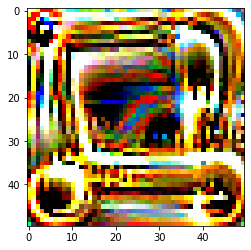

In [25]:
# Choose an integer in the range 0-9 to select the patch
patch_id = 1

# Load the patches
with gzip.open(os.path.join(os.getcwd(), "assets/imagenet_patch.gz"), 'rb') as f:
    imagenet_patch = pickle.load(f)
patches, targets, info = imagenet_patch
patch = patches[patch_id]      # get the patch with id=1

print(f"Target class: {target_to_classname[targets[patch_id].item()].split(',')[0]}")
imshow(patch[:, 112-25: 112+25, 112-25: 112+25], figsize=None)

# **Apply the patch to the images**

Once the patch is loaded you can instantiate the ApplyPatch module before the normalizer.



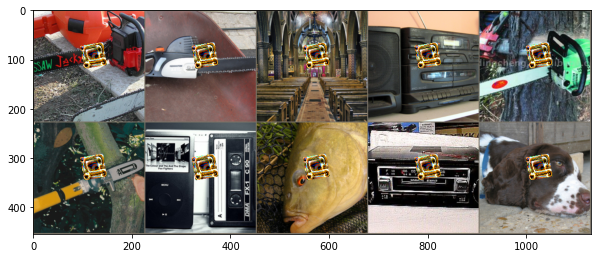

In [26]:
# Instantiate the ApplyPatch module setting the patch and the affine transformation that will be applied
apply_patch = ApplyPatch(patch, patch_size=info['patch_size'],
                         translation_range=(.2, .2),    # translation fraction wrt image dimensions
                         rotation_range=(-45, 45),             # maximum absolute value of the rotation in degree
                         scale_range=(0.7, 1)           # scale range wrt image dimensions
                         )

# For convenience the preprocessing steps are splitted to compute also the clean predictions
normalizer = Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
patch_normalizer = Compose([apply_patch, normalizer])

# Load the data
preprocess = Compose([Resize(256), CenterCrop(224), ToTensor()])    # ensure images are 224x224
dataset = ImageFolder(os.path.join(os.getcwd(), "assets/data"),
                      transform=preprocess,
                      target_transform=target_transforms)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)
x, y = next(iter(data_loader))  # load a mini-batch
x_clean = normalizer(x)
x_adv = patch_normalizer(x)

from utils.visualization import _tensor_to_show
import matplotlib.pyplot as plt


imshow(torchvision.utils.make_grid(x_adv.cpu().detach(), nrow=5), 
       transforms=patch_normalizer, figsize=(10,20))
plt.show()

# **Test the patch**

Now you can collect the predictions assigned by the classifier of your choice to the perturbed images.

In [27]:
# Load model
model = models.alexnet(pretrained=True)
model.eval()

# Test the model with the clean images
output_clean = model(x_clean)
clean_predictions = torch.argmax(output_clean, dim=1).cpu().detach().numpy()

# Test the model with the images corrupted by the patch
output_adv = model(x_adv)
adv_predictions = torch.argmax(output_adv, dim=1).cpu().detach().numpy()

print("\nPredictions:")
for true_label, clean_pred, adv_pred in list(zip(y, clean_predictions, adv_predictions)):
    print(f"True label: {target_to_classname[true_label.item()].split(',')[0]} -> "
          f"Clean: {target_to_classname[clean_pred].split(',')[0]} -> "
          f"Adv.: {target_to_classname[adv_pred].split(',')[0]}")


Predictions:
True label: chain saw -> Clean: chain saw -> Adv.: lawn mower
True label: chain saw -> Clean: chain saw -> Adv.: cornet
True label: church -> Clean: altar -> Adv.: trombone
True label: cassette player -> Clean: tape player -> Adv.: trombone
True label: chain saw -> Clean: chain saw -> Adv.: cornet
True label: chain saw -> Clean: chain saw -> Adv.: cornet
True label: cassette player -> Clean: desktop computer -> Adv.: cornet
True label: tench -> Clean: tench -> Adv.: cornet
True label: cassette player -> Clean: CD player -> Adv.: grille
True label: English springer -> Clean: English springer -> Adv.: cornet


# **Evaluation with Imagenet-Patch**

In case collecting the clean predictions is not in your interest, the pipeline becomes even simpler: you instantiate the preprocessing containing the ApplyPatch module.
From this step on the code can follow the classical PyTorch evaluation framework!

In [33]:
set_all_seed(42)

correct_clean = 0
correct_adv = 0
n_samples = 0
with torch.no_grad():
    for x,y in data_loader:
        x, y = next(iter(data_loader))  # load a mini-batch
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()

        x_clean = normalizer(x)
        x_adv = patch_normalizer(x)

        pred_clean = model(x_clean)
        correct_clean += (pred_clean.argmax(1) == y).sum().item()

        pred_adv = model(x_adv)
        correct_adv += (pred_adv.argmax(1) == y).sum().item()

        n_samples += x.shape[0]

correct_clean /= n_samples
correct_adv /= n_samples
print(f"Clean accuracy: {(100*correct_clean):>0.1f}% \n")
print(f"Robust accuracy: {(100*correct_adv):>0.1f}% \n")

Clean accuracy: 52.0% 

Robust accuracy: 20.0% 

